In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

%matplotlib inline

In [3]:
import astropy
from scipy.integrate import quad
from scipy.integrate import trapz
from astropy import units
from astropy import cosmology
import time

## Load and examine data

In [4]:
data = pd.read_csv('supernova_data.txt', header=18, delimiter=' ')

In [5]:
numerical_data = np.array(np.array(data)[:, 1:], dtype=float)

<Container object of 3 artists>

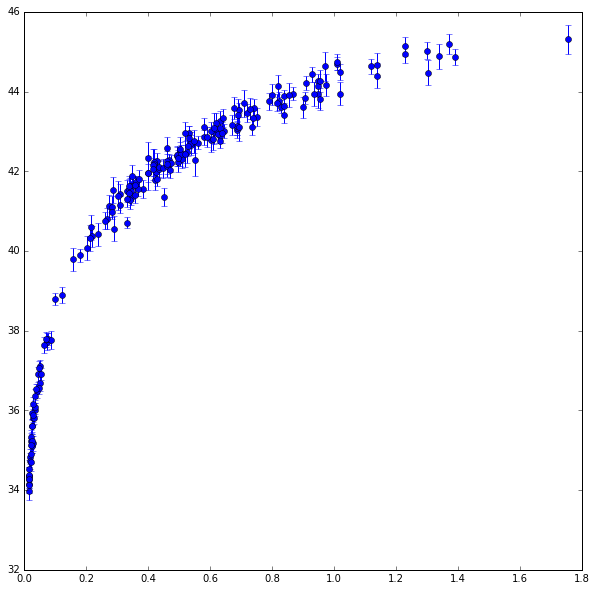

In [5]:
plt.figure(figsize=(10, 10))
plt.errorbar(numerical_data[:, 0], numerical_data[:, 1], numerical_data[:, 2], fmt='o')

In [9]:
H0 = 67
Om0 = 0.27
Ode0 = 1 - Om0
model = astropy.cosmology.wCDM(H0, Om0, Ode0)

0.0519286098086


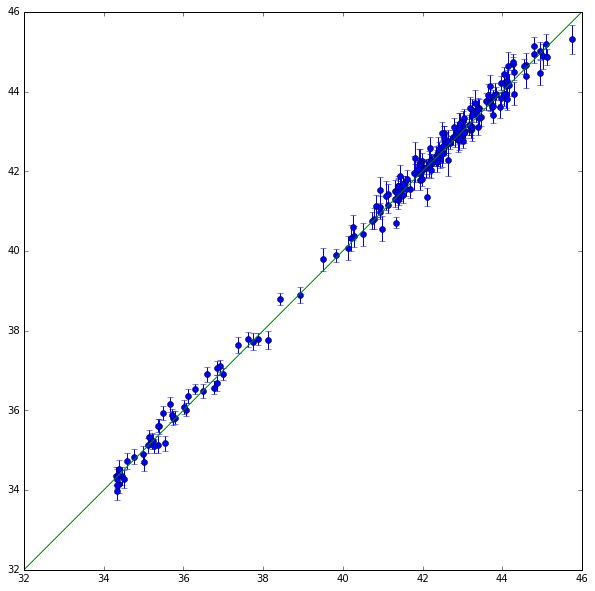

In [10]:
mu_estimate = np.array(model.distmod(numerical_data[:, 0]))
plt.figure(figsize=(10, 10))
plt.errorbar(mu_estimate, numerical_data[:, 1], numerical_data[:, 2], fmt='o')
plt.plot([32, 46], [32, 46])
print np.mean((numerical_data[:, 1] - mu_estimate)**2)

## Prepare variable fidelity modeling

In [9]:
def get_trapz_integral(z, model, interval_number=50):
    points = np.linspace(0, z, interval_number)
    values = [model._inv_efunc_scalar(point, *model._inv_efunc_scalar_args) for point in points]
    return trapz(values, points)

In [7]:
def calculate_distmod(z_array, model, interval_number=50):
    Ok0 = model._Ok0
    sqrtOk0 = np.sqrt(abs(Ok0))
    
    if interval_number == 0:
        comoving_distance_function = lambda z: quad(model._inv_efunc_scalar, 0, z,
                          args=model._inv_efunc_scalar_args)[0]
    else:
        comoving_distance_function = lambda z: get_trapz_integral(z, model, interval_number)
        
    comoving_distance = np.array(map(comoving_distance_function, z_array), dtype=float)   
    hubble_distance = model._hubble_distance
    comoving_transverse_distance_z1z2 = hubble_distance / sqrtOk0 * (np.sinh(sqrtOk0 * comoving_distance) * (Ok0 >= 0) +
                                                                     np.sin(sqrtOk0 * comoving_distance) * (Ok0 < 0))
    
    comoving_transverse_distance = comoving_transverse_distance_z1z2
    luminosity_distance = np.array((1. + z_array) * comoving_transverse_distance)
    values = 5. * np.log10(abs(luminosity_distance)) + 25.0
    return values

In [8]:
def get_loglikelihood(model, z_array, mu_array, mu_array_errors, level_number=10):
    mu_estimate = calculate_distmod(z_array, model, level_number)
    return np.sum(-(mu_estimate - mu_array)**2 / 2 / mu_array_errors**2)

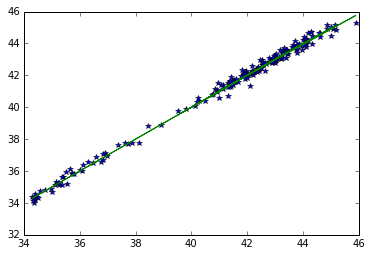

In [14]:
# test our functions
my_distances = calculate_distmod(numerical_data[:, 0], model, 2)
my_distances_second = calculate_distmod(numerical_data[:, 0], model, 1000)
astropy_distances = model.distmod(numerical_data[:, 0])
plt.plot(my_distances, numerical_data[:, 1], '*')
plt.plot(my_distances, astropy_distances)

# Generate variable fidelity sample

In [14]:
H0 = 67
# Om0 = 0.27
# Ode0 = 1 - Om0
# w0 = -1.01

sample_size = 1000
points = np.random.rand(sample_size, 3)
# points[:, 2] = 2 * (points[:, 2] - 1)
points[:, 0] = points[:, 0] * 20 + 60
coarse_values = np.zeros((sample_size, 1))
fine_values = np.zeros((sample_size, 1))

model_list = []
for point in points:
    # model = astropy.cosmology.wCDM(H0, point[0], point[1], point[2])
    model_list.append(astropy.cosmology.wCDM(point[0], point[1], point[2]))
    
start_time = time.time()
for index, point in enumerate(points):
    print index
    fine_values[index] = get_loglikelihood(model_list[index], numerical_data[:, 0], numerical_data[:, 1], numerical_data[:, 2], 100)
print time.time() - start_time

start_time = time.time()
for index, point in enumerate(points):
    print index
    coarse_values[index] = get_loglikelihood(model_list[index], numerical_data[:, 0], numerical_data[:, 1], numerical_data[:, 2], 3)
print time.time() - start_time

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

19.096403115
[[ 1.          0.99848854]
 [ 0.99848854  1.        ]]


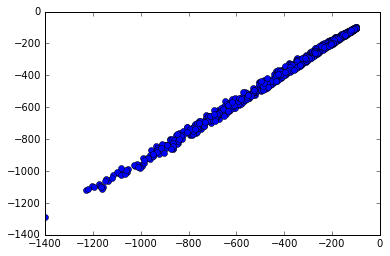

In [15]:
plt.plot(fine_values, coarse_values, 'o')
print np.mean(np.abs(fine_values - coarse_values))
print np.corrcoef(fine_values.T, coarse_values.T)

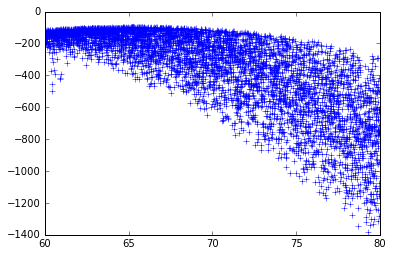

In [13]:
plt.plot(points[:, 0], fine_values, '+')

In [11]:
np.savetxt('points_close.csv', points)
np.savetxt('values_close_100.csv', fine_values)
np.savetxt('values_close_3.csv', coarse_values)

In [ ]:
fine_values